# Linear and Non-linear Filtering

## Import necessary libraries

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Define the function for plotting images

The `export_img` function to plot original and filtered images side by side:

In [2]:
def export_img(original, filtered, name):
    # Convert to 8-bit unsigned integer for plotting
    original = original.astype('uint8')
    filtered = filtered.astype('uint8')

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(filtered, cv.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('on')

    plt.show()

## Linear filtering

### Load image

Load an image and convert to float32:

In [3]:
image = cv.imread('./images/rabit.jpg')
image = image.astype('float32')

### Convolution function

The `convolution` function takes image and kernel as parameters and return the convolution:

In [4]:
def convolution(image: np.array, kernel: np.array) -> np.array:
    # Get shape of the original image and the kernel
    image_height, image_width, num_channels = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculate the output size
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # Initialize the result matrix
    output = np.zeros((output_height, output_width, num_channels), dtype=np.float32)

    # Perform the convolution
    for channel in range(num_channels):
        for i in range(output_height):
            for j in range(output_width):
                # Extract a patch from the image
                image_patch = image[i:i+kernel_height, j:j+kernel_width, channel]

                # Perform element-wise multiplication and sum
                output[i, j, channel] = np.sum(image_patch * kernel)

    return output

### Identity filter

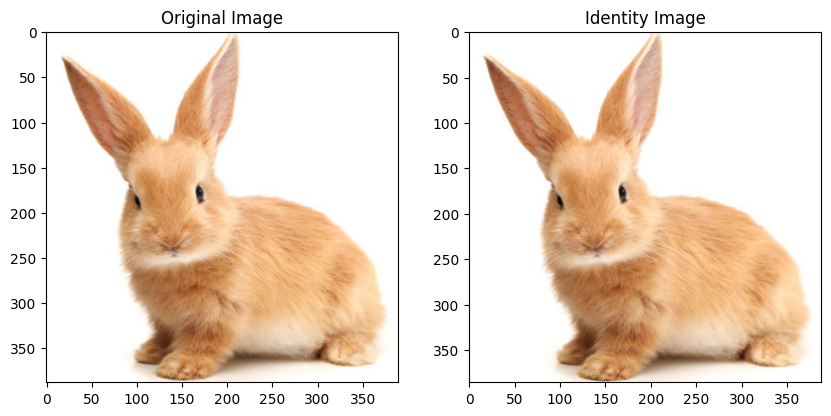

In [5]:
kernel = np.array([[0, 0, 0],
                   [0, 1, 0],
                   [0, 0, 0]], dtype=np.float32)

identity_image = convolution(image, np.array(kernel))
export_img(image, identity_image, "Identity Image")

### Edge detection

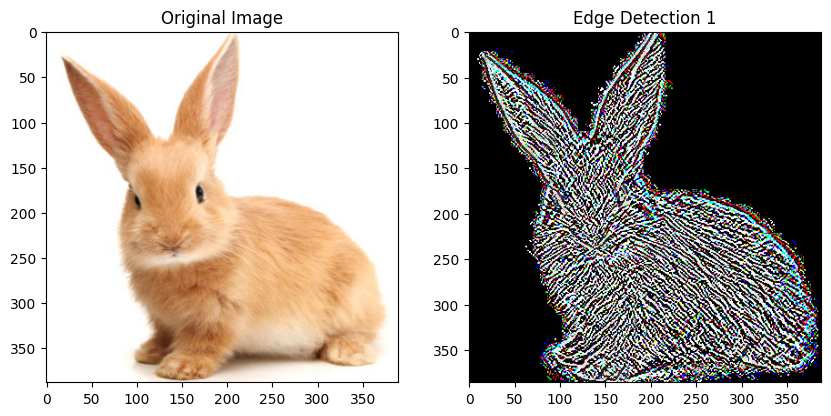

In [6]:
kernel = np.array([[ 1, 0, -1],
                   [ 0, 0,  0],
                   [-1, 0,  1]], dtype=np.float32)

edge_detection_1 = convolution(image, kernel)
export_img(image, edge_detection_1, "Edge Detection 1")

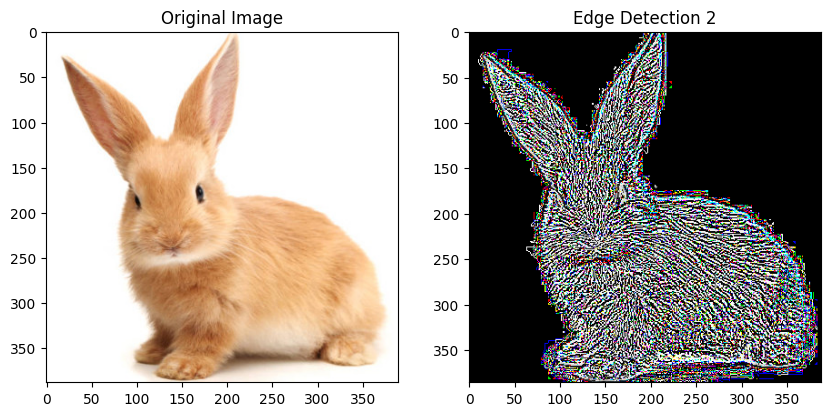

In [7]:
kernel = np.array([[ 0, -1,  0],
                   [-1,  4, -1],
                   [ 0, -1,  0]], dtype=np.float32)

edge_detection_2 = convolution(image, kernel)
export_img(image, edge_detection_2, "Edge Detection 2")

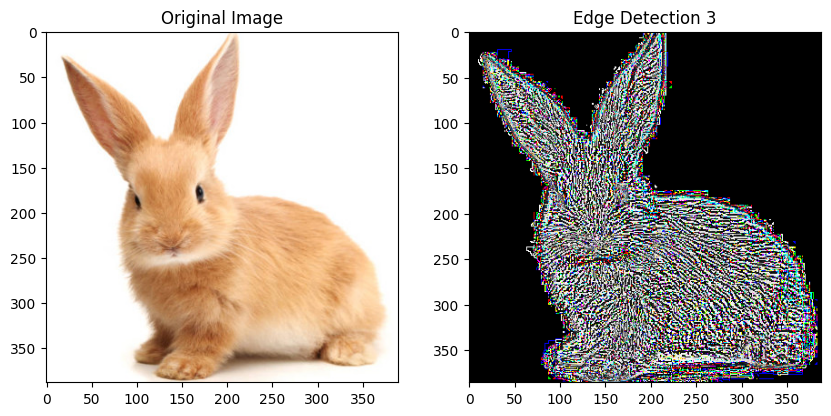

In [8]:
kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]], dtype=np.float32)

edge_detection_3 = convolution(image, kernel)
export_img(image, edge_detection_3, "Edge Detection 3")

### Sharpen filter

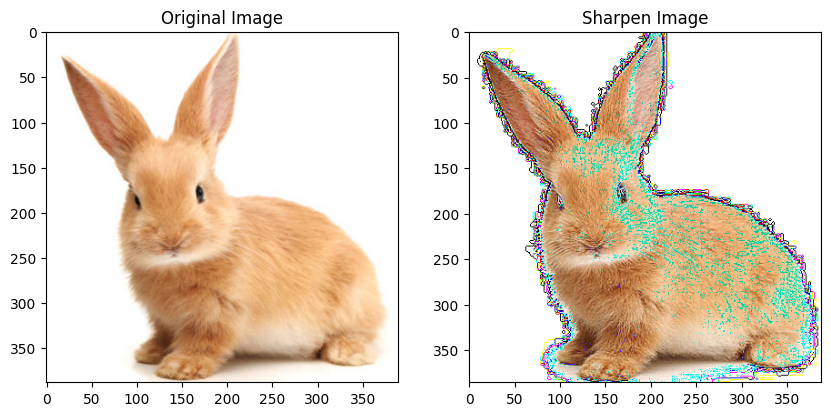

In [9]:
kernel = np.array([[ 0, -1,  0],
                   [-1,  5, -1],
                   [ 0, -1,  0]], dtype=np.float32)
sharpen_image = convolution(image, kernel)
export_img(image, sharpen_image, "Sharpen Image")

### Box blur filter

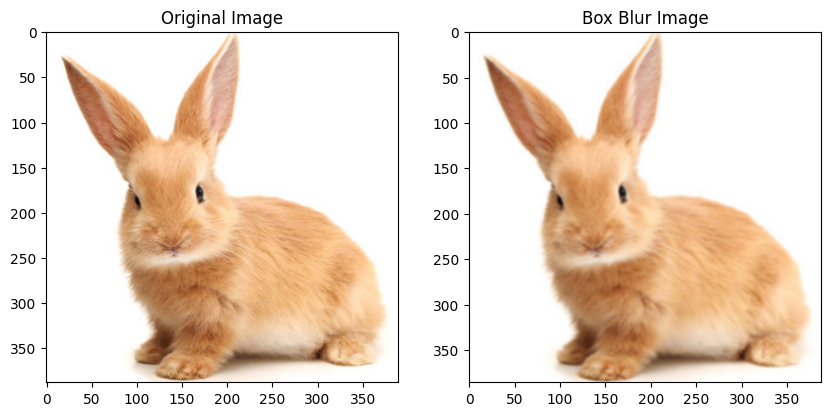

In [10]:
kernel = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]], dtype=np.float32)
kernel /= 9

box_blur_image = convolution(image, kernel)
export_img(image, box_blur_image, "Box Blur Image")

We can also use the functions: [cv.blur()](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37) or [cv.boxFilter](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gad533230ebf2d42509547d514f7d3fbc3).

### Gaussian Blur (or Gaussian Smoothing)

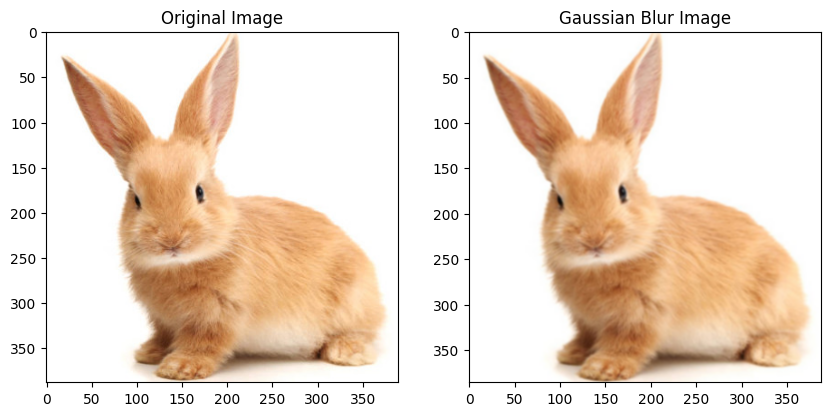

In [11]:
kernel = np.array([[1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]], dtype=np.float32)
kernel /= 16

gaussian_blur_image = convolution(image, kernel)
export_img(image, gaussian_blur_image, "Gaussian Blur Image")

We can create a Gaussian kernel with the function [cv.getGaussianKernel()](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gac05a120c1ae92a6060dd0db190a61afa):

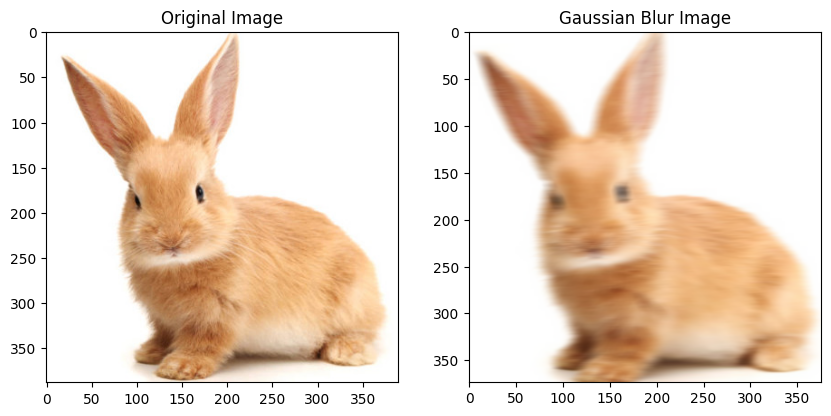

In [12]:
# Create a kernel with size 15x15 and the sigma=1
kernel = cv.getGaussianKernel(225, 5)
kernel = np.resize(kernel, (15, 15))

gaussian_blur_image = convolution(image, kernel)
export_img(image, gaussian_blur_image, "Gaussian Blur Image")

We can also use the function [cv.GaussianBlur()](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1):

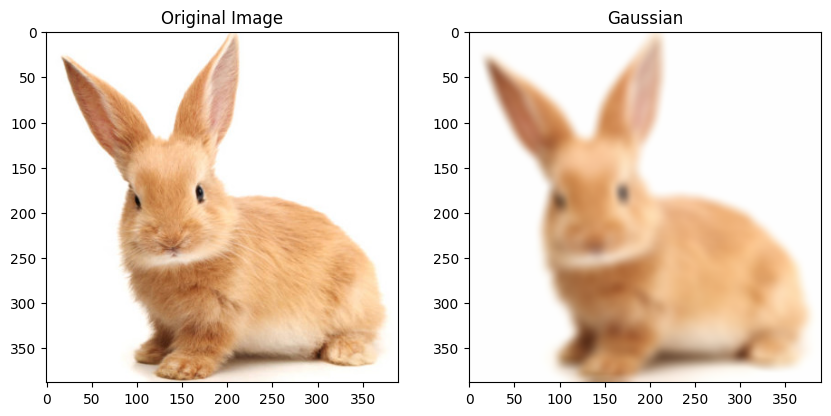

In [13]:
gaussian_blur_image = cv.GaussianBlur(image, (15, 15), 5)
export_img(image, gaussian_blur_image, 'Gaussian')

### Bilateral filter

In [14]:
def bilateral_filter(image, diameter, sigma_color, sigma_space):
    # Get the dimensions of the input image
    height, width, num_channels = image.shape

    # Create an output image of the same size as the input
    output = np.zeros_like(image)

    # Pre-compute the spatial Gaussian kernel
    spatial_kernel = np.zeros((diameter, diameter), dtype=np.float32)
    for i in range(-diameter // 2, diameter // 2 + 1):
        for j in range(-diameter // 2, diameter // 2 + 1):
            spatial_kernel[i + diameter // 2, j + diameter // 2] = np.exp(-(i ** 2 + j ** 2) / (2 * sigma_space ** 2))

    # Apply the bilateral filter to the image
    for channel in range(num_channels):
        for y in range(height):
            for x in range(width):
                pixel_value = 0.0
                normalization = 0.0

                for i in range(-diameter // 2, diameter // 2 + 1):
                    for j in range(-diameter // 2, diameter // 2 + 1):
                        # Get neighboring pixel coordinates
                        ny = y + i
                        nx = x + j

                        # Check bounds
                        if 0 <= ny < height and 0 <= nx < width:
                            # Compute intensity difference
                            intensity_diff = np.abs(image[ny, nx, channel] - image[y, x, channel])

                            # Compute the intensity Gaussian weight
                            intensity_weight = np.exp(-(intensity_diff ** 2) / (2 * sigma_color ** 2))

                            # Combine the spatial and intensity weights
                            weight = intensity_weight * spatial_kernel[i + diameter // 2, j + diameter // 2]

                            # Update the pixel value and normalization
                            pixel_value += image[ny, nx, channel] * weight
                            normalization += weight

                # Normalize the pixel value
                output[y, x, channel] = pixel_value / normalization

    return output


Apply with diameter = 9, sigma_color = sigma_space = 75:

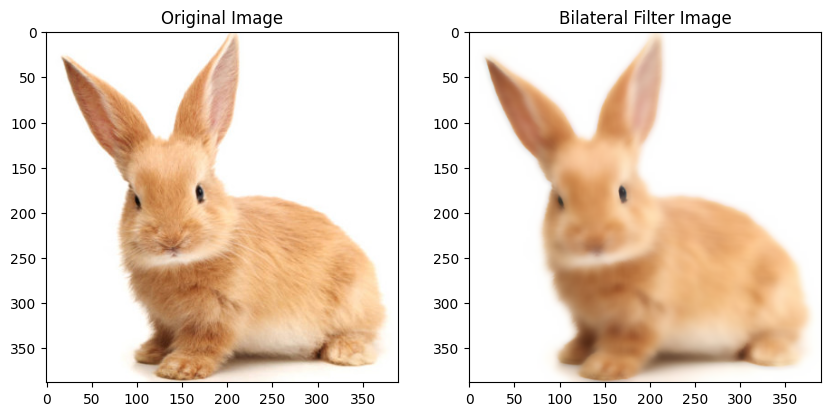

In [15]:
bilateral_filtered_image = bilateral_filter(image, 9, 75, 75)
export_img(image, bilateral_filtered_image, 'Bilateral Filter Image')

We can also use the function [cv.bilateralFilter()](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed):

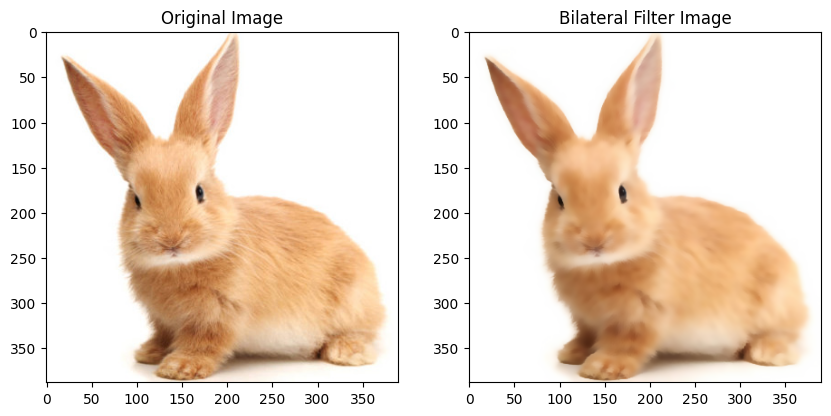

In [16]:
bilateral_filtered_image = cv.bilateralFilter(image, 9, 75, 75)
export_img(image, bilateral_filtered_image, 'Bilateral Filter Image')

## Non-linear filtering

### Load image

Load an image and convert to float32:

In [17]:
image = cv.imread('./images/girl.jpg')
image = image.astype('float32')

### Mean filter

Define the `mean_filter` function. In this implementation I keep the border values unchanged. You can extend the border values with values at boundary or with 0s (zero-padding).

In [18]:
def mean_filter(image, kernel_size):
    # Ensure that kernel_size is an odd number
    assert kernel_size % 2 == 1

    # Get the dimensions of the input image
    height, width, num_channels = image.shape

    # Create an output image of the same size as the input
    output = np.zeros_like(image)

    # Define a (kernel_size x kernel_size) mean filter kernel
    kernel = np.array([[1] * kernel_size] * kernel_size, dtype=np.float32)
    kernel /= (kernel_size * kernel_size)

    # Apply the mean filter to the image
    padding = kernel_size // 2
    for channel in range(num_channels):
        for i in range(padding, height - padding):
            for j in range(padding, width - padding):
                # Extract a (kernel_size x kernel_size) neighborhood around the pixel
                neighborhood = image[i - padding:i + padding + 1, j - padding:j + padding + 1, channel]

                # Apply the mean filter by multiplying the kernel with the neighborhood
                filtered_pixel = np.sum(neighborhood * kernel)

                # Set the filtered pixel value in the output image
                output[i, j, channel] = filtered_pixel

    return output


Apply with the kernel 3x3 and 5x5:

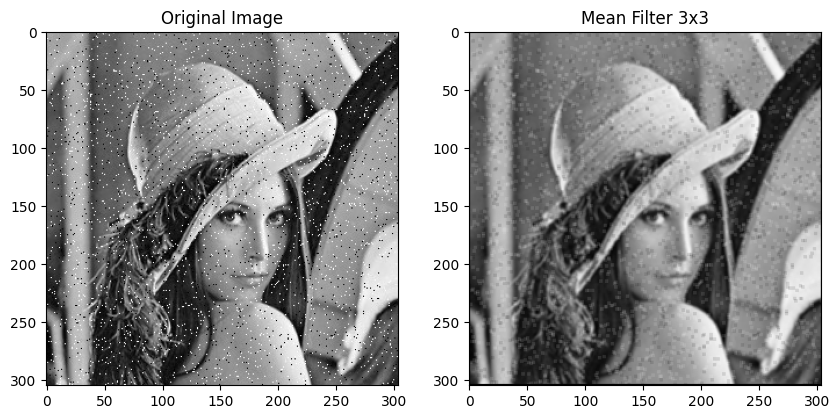

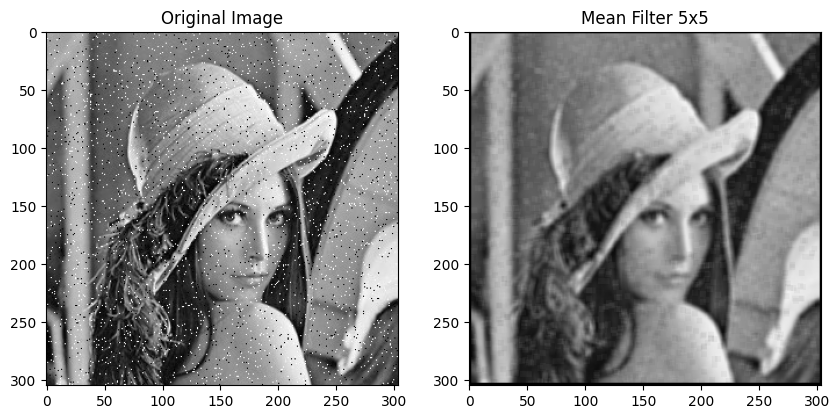

In [19]:
mean_filtered_3 = mean_filter(image, 3)
export_img(image, mean_filtered_3, 'Mean Filter 3x3')

mean_filtered_5 = mean_filter(image, 5)
export_img(image, mean_filtered_5, 'Mean Filter 5x5')

### Median filter

Define the `median_filter` function. In this implementation I keep the border values unchanged. You can extend the border values with values at boundary or with 0s (zero-padding).

In [20]:
def median_filter(image, kernel_size):
    # Ensure that kernel_size is an odd number
    assert kernel_size % 2 == 1

    # Get the dimensions of the input image
    height, width, num_channels = image.shape

    # Create an output image of the same size as the input
    output = np.zeros_like(image)

    # Apply the mean filter to the image
    padding = kernel_size // 2
    for channel in range(num_channels):
        for i in range(padding, height - padding):
            for j in range(padding, width - padding):
                # Extract a (kernel_size x kernel_size) neighborhood around the pixel
                neighborhood = image[i - padding:i + padding + 1, j - padding:j + padding + 1, channel]

                # Apply the mean filter by multiplying the kernel with the neighborhood
                filtered_pixel = np.median(neighborhood)

                # Set the filtered pixel value in the output image
                output[i, j, channel] = filtered_pixel

    return output


Apply with the kernel 3x3 and 5x5:

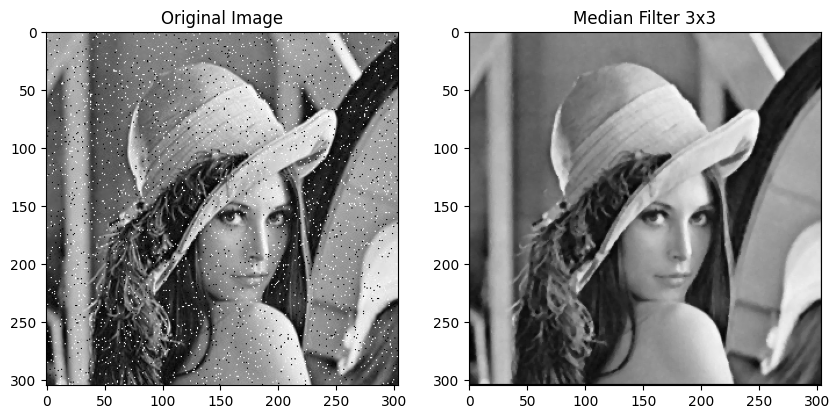

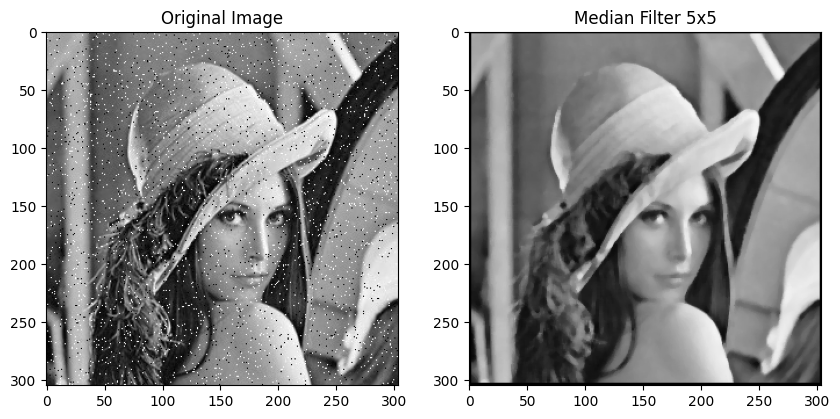

In [21]:
median_filtered_3 = median_filter(image, 3)
export_img(image, median_filtered_3, 'Median Filter 3x3')

median_filtered_5 = median_filter(image, 5)
export_img(image, median_filtered_5, 'Median Filter 5x5')

## References

1. [2D Convolution (Image Filtering) - OpenCV](https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)

2. [Image Filtering - OpenCV](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html)

3. [Kernel (Image Processing) - Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing))